<a href="https://colab.research.google.com/github/BenjaminDeporte/MVA/blob/master/RecVis24_A3_Benjamin_Deporte.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#RecVis 2024/2025 - Assignment 3: Sketch image classification competition

First, please, make sure that a GPU runtime has been selected before running this notebook. Go to `Runtime > Change runtime type > Hardware accelerator` and select the GPU one.

Then, you can download the simple baseline code from GitHub and install the python requirements:

In [1]:
!git clone https://github.com/willowsierra/recvis24_a3.git

Cloning into 'recvis24_a3'...
remote: Enumerating objects: 42, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 42 (delta 19), reused 32 (delta 14), pack-reused 0 (from 0)
Receiving objects: 100% (42/42), 9.93 KiB | 4.97 MiB/s, done.
Resolving deltas: 100% (19/19), done.


In [ ]:
!pip install -r recvis24_a3/requirements.txt

You will need to download the datasets from the [Kaggle competition](https://www.kaggle.com/competitions/mva-recvis-2023/data). To that end, you can retrieve your Kaggle account API token. On Kaggle website:

1. Go to your account, Scroll to API section and Click Expire API Token to remove previous tokens

2. Click on Create New API Token - It will download kaggle.json file on your machine.

Then, open the file, and paste it on the next code cell.

In [ ]:
!mkdir ~/.kaggle #create the .kaggle folder in your root directory
!echo '{"username":"benjamindeporte","key":"1fb6871a94e60e4838224dde5c5f4eb8"}' > ~/.kaggle/kaggle.json #write kaggle API credentials to kaggle.json
!chmod 600 ~/.kaggle/kaggle.json  # set permissions
!pip install kaggle #install the kaggle library

mkdir: cannot create directory ‘/root/.kaggle’: File exists


Next, download the competition dataset and unzip it:

In [ ]:
!kaggle competitions download -c mva-recvis-2024
!unzip mva-recvis-2024.zip

Streaming output truncated to the last 5000 lines.
  inflating: sketch_recvis2024/sketch_recvis2024/train_images/n04447861/img_irxkb.jpeg  
  inflating: sketch_recvis2024/sketch_recvis2024/train_images/n04447861/img_jzos8.jpeg  
  inflating: sketch_recvis2024/sketch_recvis2024/train_images/n04447861/img_kbikw.jpeg  
  inflating: sketch_recvis2024/sketch_recvis2024/train_images/n04447861/img_kc8gy.jpeg  
  inflating: sketch_recvis2024/sketch_recvis2024/train_images/n04447861/img_ks1m4.jpeg  
  inflating: sketch_recvis2024/sketch_recvis2024/train_images/n04447861/img_le2nt.jpeg  
  inflating: sketch_recvis2024/sketch_recvis2024/train_images/n04447861/img_m0ptr.jpeg  
  inflating: sketch_recvis2024/sketch_recvis2024/train_images/n04447861/img_n4da4.jpeg  
  inflating: sketch_recvis2024/sketch_recvis2024/train_images/n04447861/img_o7xu6.jpeg  
  inflating: sketch_recvis2024/sketch_recvis2024/train_images/n04447861/img_ou994.jpeg  
  inflating: sketch_recvis2024/sketch_recvis2024/train_imag

Finally, you can run the simple baseline:

In [ ]:
# !python recvis24_a3/main.py --data /content/sketch_recvis2024/sketch_recvis2024

In [ ]:
# !python /content/recvis24_a3/evaluate.py --data /content/sketch_recvis2024/sketch_recvis2024 --model_name basic_cnn --model experiment/model_best.pth

In [ ]:
import numpy as np
import os
import random
import matplotlib.pyplot as plt

In [ ]:
# we'll look at some images first, picking randomly directories in the training set,
# then random images within the random directories

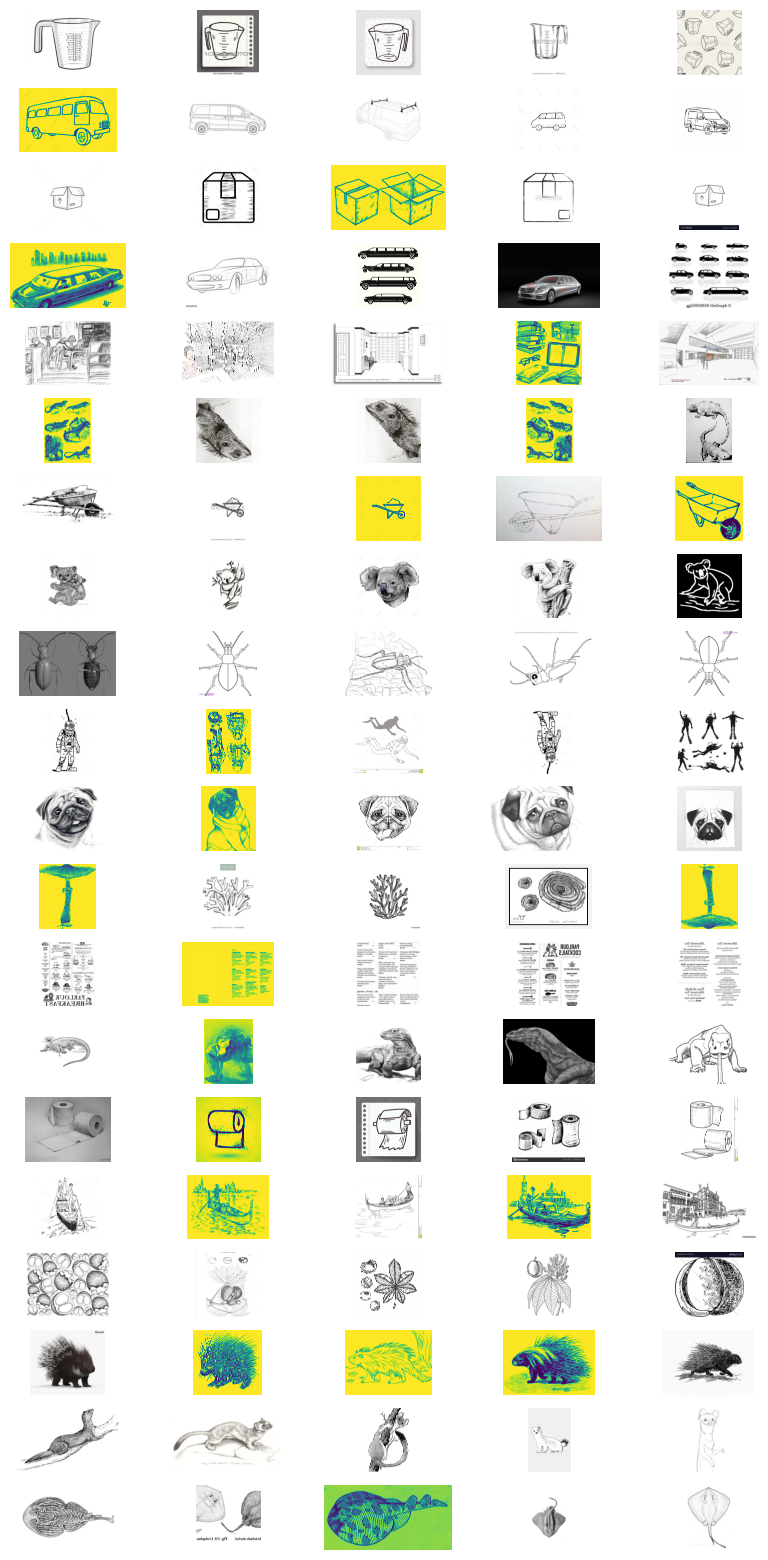

In [ ]:
train_images_path = '/content/sketch_recvis2024/sketch_recvis2024/train_images'

list_dirs = os.listdir(train_images_path)

# each directory is the set of a given class
N_DIRS = 20
random_dirs = random.sample(list_dirs, N_DIRS)

# pick some images for each class
N_IMAGES = 5
fig, axs = plt.subplots(nrows=N_DIRS, ncols=N_IMAGES, figsize=(N_IMAGES*2, N_DIRS*1))

for i,d in enumerate(random_dirs):
  img_path = train_images_path + '/' + d
  list_imgs = os.listdir(img_path)
  random_imgs = random.sample(list_imgs, N_IMAGES)
  for j,img in enumerate(random_imgs):
    axs[i,j].imshow(plt.imread(img_path + '/' + img))
    axs[i,j].axis('off')

In [ ]:
# THEN WE WORK ON GETTING A BASELINE WITH A BEEEFED-UP CNN WITH EARLY STOPPING AND A GOOD OPTIMIZER

# we need to copy paste most of the code from recvis24_3 so we can modify/add stuff

In [ ]:
# model

import torch.nn as nn
import torch.nn.functional as F

nclasses = 500


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv3 = nn.Conv2d(20, 20, kernel_size=5)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, nclasses)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.relu(F.max_pool2d(self.conv3(x), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

In [ ]:
# basic early stopping mechanism (inspired from Stack Overflow)

class EarlyStoppingCallback:
    def __init__(self, patience=1, min_delta=0):
        # how many epochs do we allow with a non-decreasing validation loss
        self.patience = patience
        # tolerance for non-decrease
        self.min_delta = min_delta
        # counts how many epochs with non decreasing validation loss
        self.counter = 0
        # current best -lowest- validation loss
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        # check if validation loss is lower than current minimum
        if validation_loss < self.min_validation_loss:
            # yes : update minimum validation loss, reset counter
            self.min_validation_loss = validation_loss
            self.counter = 0
        # no : check if we're within tolerance
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            # if not withion tolerance, increase counter...
            self.counter += 1
            if self.counter >= self.patience:
                # ... and say we're done with training
                return True
        return False

In [ ]:
# !python recvis24_a3/main.py --data /content/sketch_recvis2024/sketch_recvis2024 --epoch=3